# Dummy variable (no pooling) model for housing prices

$$
log(SP)_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha_{NH[j]} + \beta * log(LA)_i \\
\alpha_j\sim Normal(1, 0.5),\space for\space j = 1...J\space neighbourhoods\\
\beta\sim Normal(0, 0.5) \\
\sigma\sim exp(1)
$$

In [1]:
import math
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

az.style.use('arviz-darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Train/Test data
train = pd.read_csv('../../data/raw/train.csv').assign(data_type = 'train')
test = pd.read_csv('../../data/raw/test.csv').assign(data_type = 'test')

# Want to ensure the encodings of the neighbourhoods as indexes are consistent
df_full = train.append(test, ignore_index = True)
df_full['neighbourhood'] = df_full['Neighborhood'].astype('category').cat.codes+1

# Log variables
df_full['log_sales_price'] = np.log(df_full['SalePrice'])
df_full['log_lot_area'] = np.log(df_full['LotArea'])

# Train/test split
train = df_full.loc[df_full['data_type'] == 'train'].copy()
test = df_full.loc[df_full['data_type'] == 'test'].copy()

# Center and scale predictor (train)
train['log_lot_area_z'] = (train[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target (train)
train['log_sales_price_std'] = train['log_sales_price']/train['log_sales_price'].mean()

# Center and scale predictor using training data mean and std
test['log_lot_area_z'] = (test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target using training data mean
#test['log_sales_price_std'] = test['log_sales_price']/train['log_sales_price'].mean()

## Load and simulate fake data

In [3]:
no_pooling_model = pystan.StanModel(file = '../../models/dummy_variable_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cc546eff90ebf051c247c29bee2ec648 NOW.


In [4]:
npm_data_check = dict(N = len(train),
              log_sales_price = train['log_sales_price_std'],
              log_lot_area = train['log_lot_area_z'],
              neighbourhood = train['neighbourhood'],
              N_neighbourhood = len(train['Neighborhood'].unique()),
              N_test = len(test),
              log_lot_area_test = test['log_lot_area_z'],
              neighbourhood_test = test['neighbourhood'],
              alpha_sd = 0.01, 
              beta_sd = 0.1, 
              run_estimation = 0)

fit_npm_check = no_pooling_model.sampling(data=npm_data_check)
npm_df_check = fit_npm_check.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Prior predictive checks

<AxesSubplot:xlabel='log_sales_price / y_hat'>

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/IPython/core/events.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


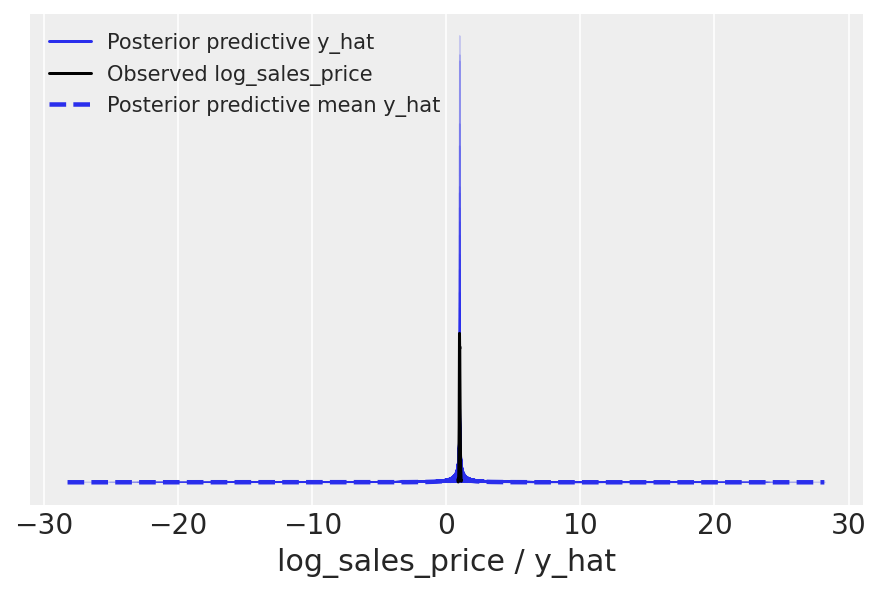

In [6]:
npm_check_az = az.from_pystan(
    posterior=fit_npm_check,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

az.plot_ppc(data = npm_check_az, kind = 'kde', data_pairs = {'log_sales_price' : 'y_hat'})

#az.plot_trace(fit_model_check, var_names=["alpha_j", "beta", "sigma"], compact = True);

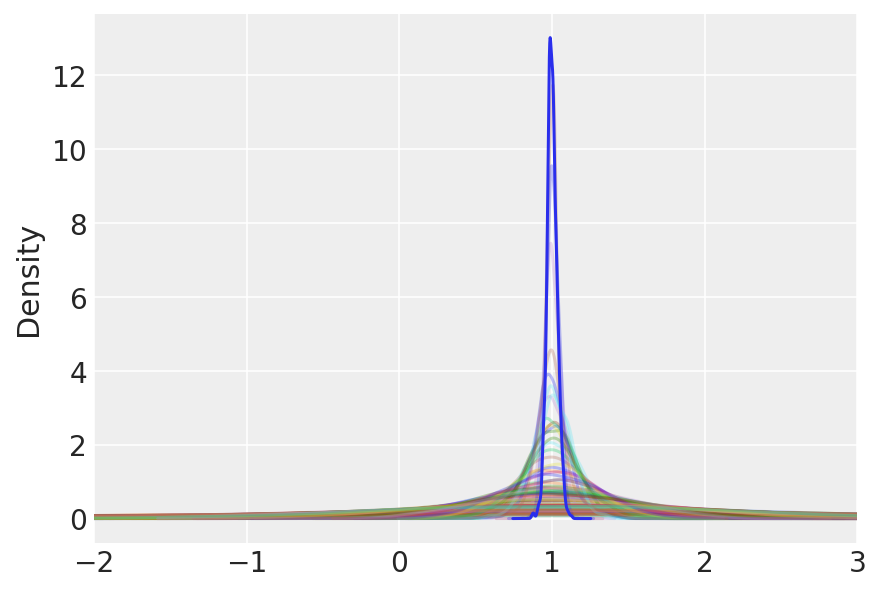

In [7]:
fig, axes = plt.subplots(1,1)

npm_df_check.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-2, 3),
                                                        ax = axes);

train['log_sales_price_std'].plot.kde(legend = False, 
                             alpha = 1,
                             ax = axes);

In [9]:
#az.plot_trace(fit_npm_check, var_names=["alpha", "beta", "sigma"], compact = True);

## Fit model on fake data and recapture known parameters (appendix?)

In [8]:
random_draw = 10
y_sim = npm_df_check.filter(regex = 'y_hat').iloc[random_draw, :]
true_parameters = npm_df_check.filter(regex = 'alpha|beta|sigma').iloc[random_draw, :]

_npm_data_check = dict(N = len(train),
              log_sales_price = y_sim,
              log_lot_area = train['log_lot_area_z'],
              neighbourhood = train['neighbourhood'],
              N_neighbourhood = len(train['Neighborhood'].unique()),
              N_test = len(test),
              log_lot_area_test = test['log_lot_area_z'],
              neighbourhood_test = test['neighbourhood'],
              alpha_sd = 0.01, 
              beta_sd = 0.1, 
              run_estimation = 1)

_fit_npm_check = no_pooling_model.sampling(data=_npm_data_check)
_npm_df_check = _fit_npm_check.to_dataframe()
fake_fit = _npm_df_check.filter(regex = 'alpha|beta|sigma')
parameter_df = pd.melt(fake_fit)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


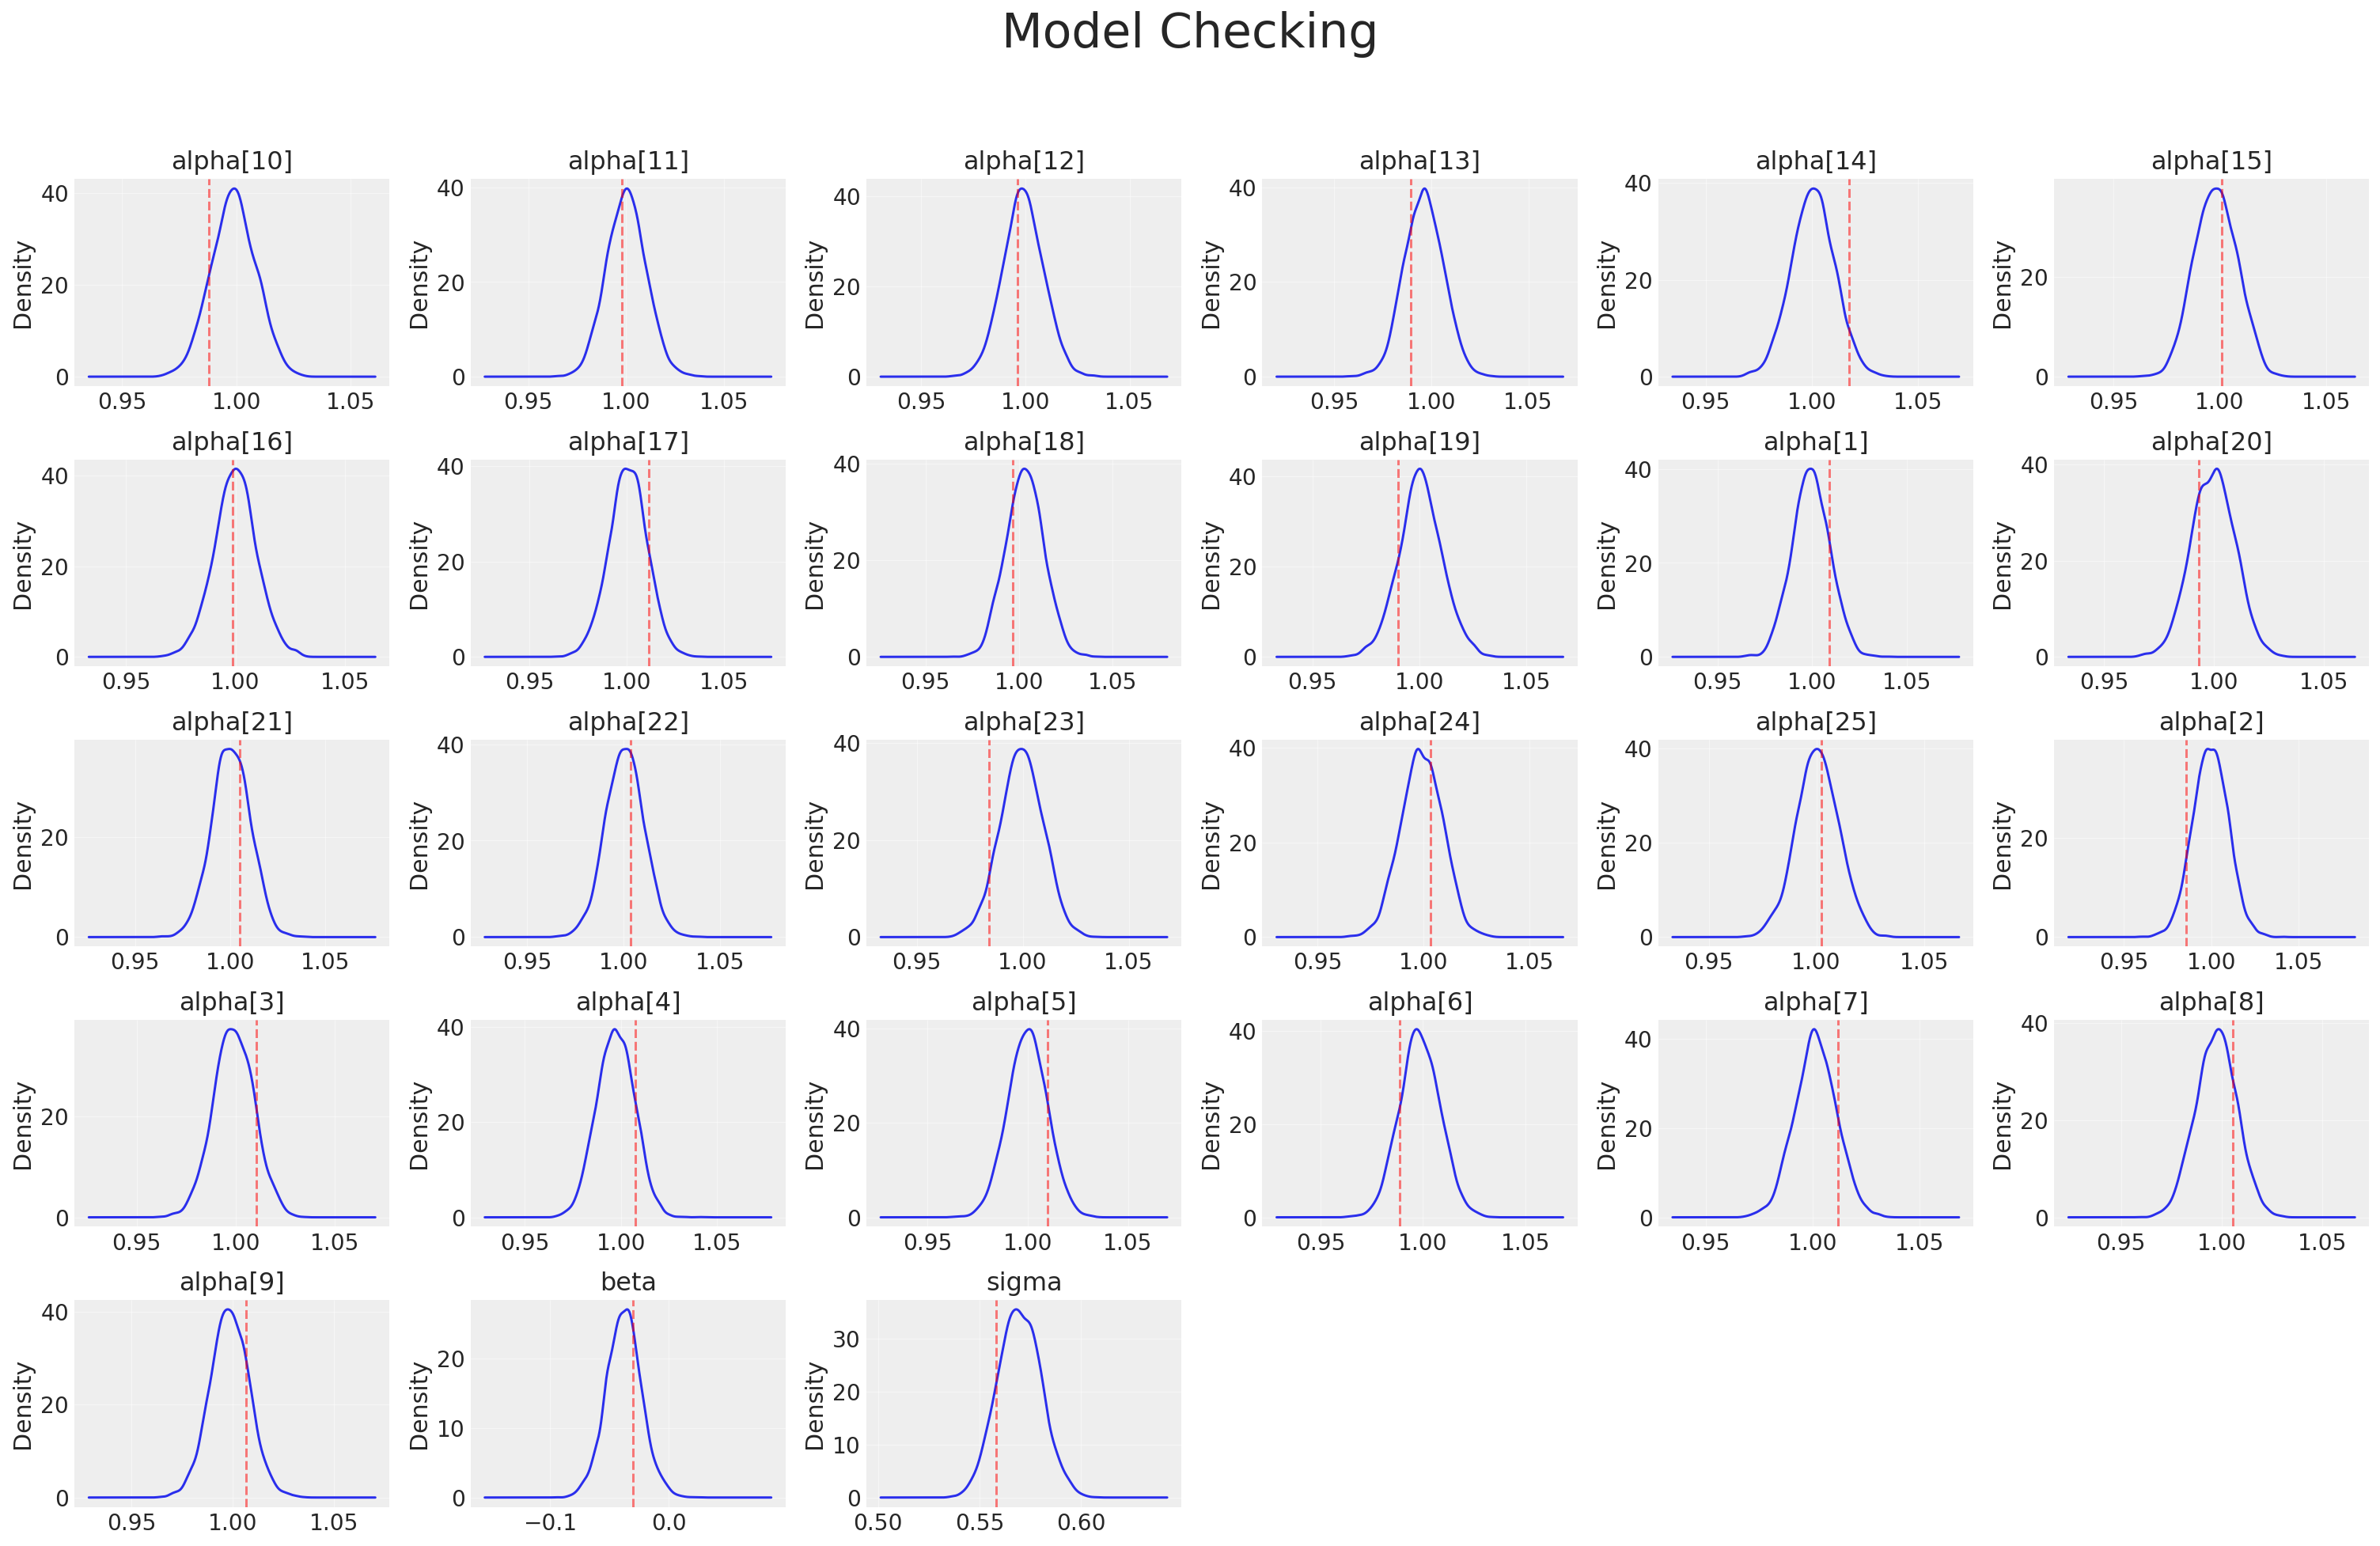

In [9]:
fig, axes = plt.subplots(nrows=max(2, math.ceil(fake_fit.shape[1] / 6)), ncols=6, sharex=False, sharey = False, figsize=(21,13))
fig.suptitle('Model Checking', y = 1.04, size = 30)
axes_list = [item for sublist in axes for item in sublist] 
parameters = parameter_df.groupby("variable")['variable'].last().sort_values(ascending=True).index
grouped = parameter_df.groupby("variable")

for parameter in parameters:
    selection = grouped.get_group(parameter)
    ax = axes_list.pop(0)
    selection.plot.kde(label=parameter, ax=ax, legend=False)
    ax.set_title(parameter)
    ax.grid(linewidth=0.25)
    ax.axvline(x=true_parameters[parameter], color='red', linestyle='--', alpha = 0.5)

# Now use the matplotlib .remove() method to delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout();

## Fit model on real data

In [ ]:
train = train[]

In [10]:
npm_data = dict(N = len(train),
              log_sales_price = train['log_sales_price_std'],
              log_lot_area = train['log_lot_area_z'],
              neighbourhood = train['neighbourhood'],
              N_neighbourhood = len(train['Neighborhood'].unique()),
              N_test = len(test),
              log_lot_area_test = test['log_lot_area_z'],
              neighbourhood_test = test['neighbourhood'],
              alpha_sd = 0.01, 
              beta_sd = 0.1, 
              run_estimation = 1)

fit_npm = no_pooling_model.sampling(data=npm_data)

npm_az = az.from_pystan(
    posterior=fit_npm,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

fit_npm_df = fit_npm.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_

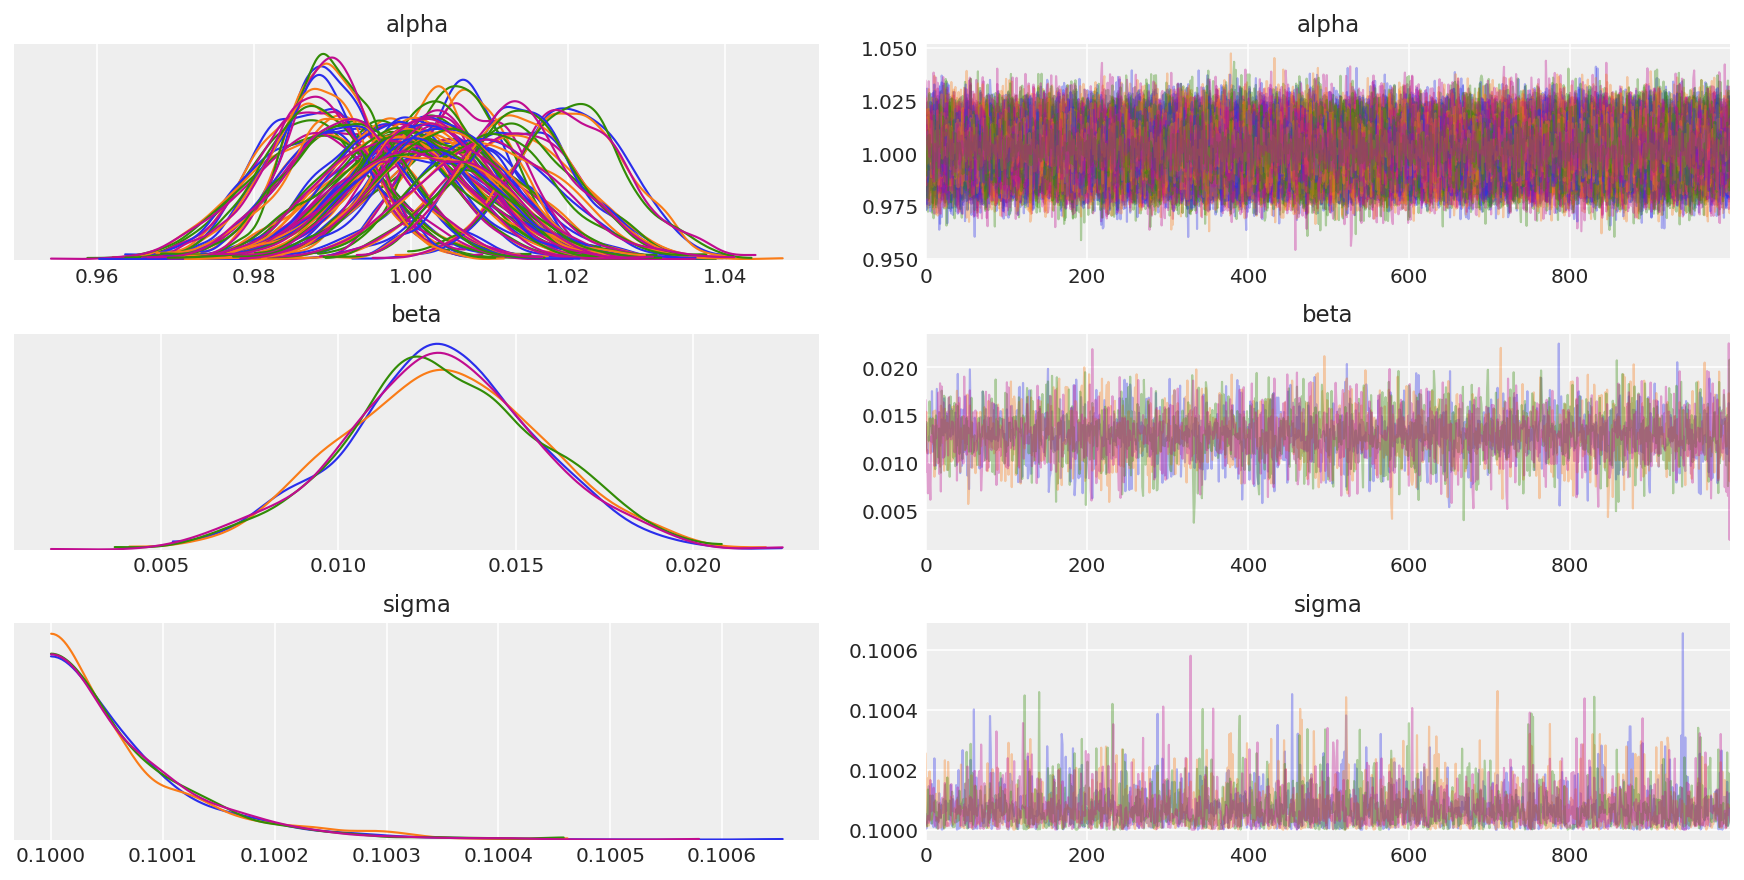

In [5]:
az.plot_trace(fit_npm, var_names=["alpha", "beta", "sigma"], compact = True);

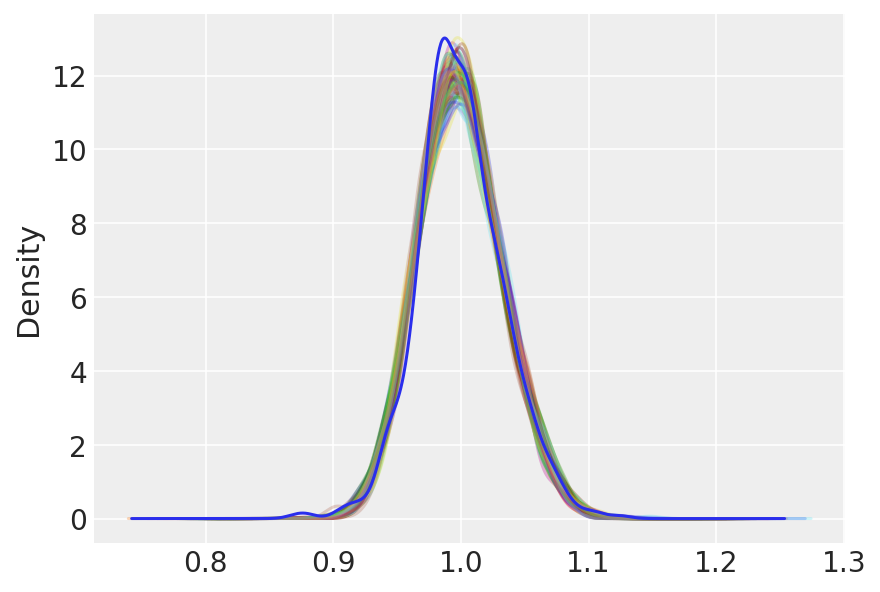

In [11]:
fig, axes = plt.subplots(1,1)

fit_npm_df.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False,
                                                               ax=axes);

train['log_sales_price_std'].plot.kde(legend = False, 
                             alpha = 1,
                             ax = axes);

<AxesSubplot:xlabel='log_sales_price / y_hat'>

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/IPython/core/events.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


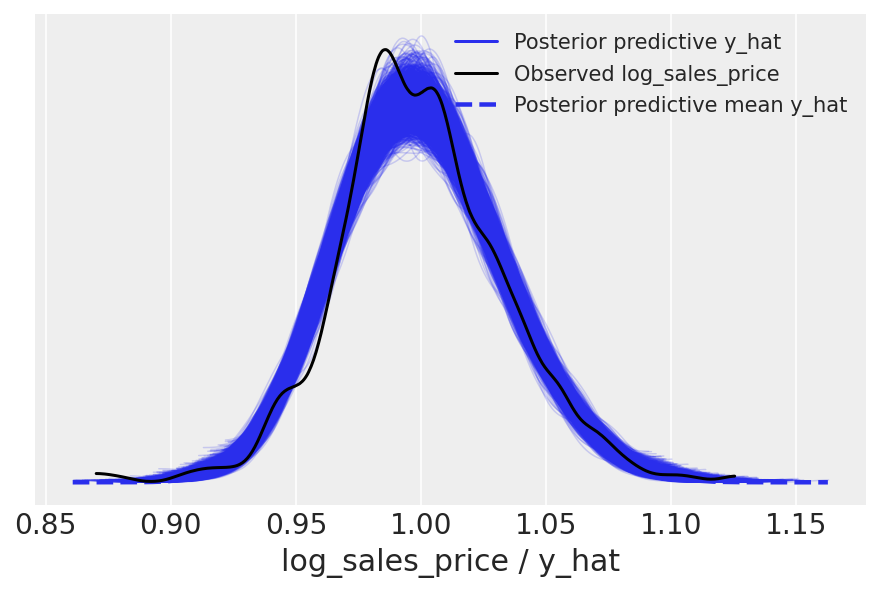

In [13]:
az.plot_ppc(data = npm_az, kind = 'kde', data_pairs = {'log_sales_price' : 'y_hat'})

In [7]:
predictions = pd.DataFrame(np.exp(fit_npm_df.filter(regex = 'y_test').mean(axis=0)*train['log_sales_price'].mean()),
                  columns = ['SalePrice'])\
                  .reset_index()\
                  .drop('index', axis = 1)

no_pooling_csv = pd.concat([test[['Id']].reset_index().drop('index', axis = 1), 
                                   predictions], axis=1)

#no_pooling_csv.to_csv('../data/submissions/dummy_no_pooling.csv', index = False)

In [18]:
%%sh
cd ../data/submissions/;
kaggle competitions submit -c house-prices-advanced-regression-techniques -f dummy_no_pooling.csv -m "Dummy variable (no pooling) model"

Successfully submitted to House Prices: Advanced Regression Techniques

100%|██████████| 33.7k/33.7k [00:05<00:00, 5.89kB/s]


In [8]:
solution = pd.read_csv('/Users/benjaminwee/Downloads/solution.csv')

In [9]:
solution.head()

,Id,SalePrice
0,1461,105000.0
1,1462,172000.0
2,1463,189900.0
3,1464,195500.0
4,1465,191500.0


In [10]:
no_pooling_csv

,Id,SalePrice
0,1461,149688.306919
1,1462,158199.298929
2,1463,201875.323037
3,1464,187663.146865
4,1465,231873.512661
...,...,...
1454,2915,95728.929642
1455,2916,95904.323950
1456,2917,184359.617829
1457,2918,153476.548091


In [8]:
from sklearn.metrics import mean_squared_log_error
submit = pd.read_csv('../../data/submissions/dummy_no_pooling.csv')
solution = pd.read_csv('/Users/benjaminwee/Downloads/solution.csv')
np.sqrt(mean_squared_log_error(solution['SalePrice'], submit['SalePrice']))

0.2567548519352068

In [15]:
import sklearn as sk